In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from keras.layers import InputLayer,Conv2D,MaxPooling2D,Flatten,Dense,AveragePooling2D,BatchNormalization,Dropout,Input,Activation
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
datadir_train_pc=r"D:\Emotion_dataset\train"
datadir_test_pc=r"D:\Emotion_dataset\test"

In [2]:
datadir_train=r"/kaggle/input/emotion-detection-fer/train"

In [3]:
datadir_test=r"/kaggle/input/emotion-detection-fer/test"

In [4]:
catgories=["angry","disgusted","fearful","happy","neutral","sad","surprised"]

In [5]:
training_data=[]
test_data=[]

In [8]:
for catgory in catgories:
    path1= os.path.join(datadir_train_pc,catgory)#D:\AMIT_CONTENT\AMIT_CV\data\train\angry,...
    class_num=catgories.index(catgory)
    for img in os.listdir(path1): #D:\AMIT_CONTENT\AMIT_CV\data\train\angry/img0,...
        #[list have all content at folder bening then malignant 0jpg,1jpg,2jpg,... loop on names of all image inside folder]
        try:
            array_of_train_img=cv2.imread(os.path.join(path1,img))#[read image in folder using open cv merge (index 0jpg with image)]
           # array_of_train_img=cv2.cvtColor(array_of_train_img, cv2.COLOR_BGR2GRAY)
            #resize image 
            array_of_train_img=cv2.resize(array_of_train_img,(224,224))
            training_data.append([array_of_train_img,class_num])
        except Exception as ex:
            pass
# try except to avoid any error   



for catgory in catgories:
    path3=os.path.join(datadir_test_pc,catgory)
    class_num=catgories.index(catgory)
    for img in os.listdir(path3):
        try:
            array_of_test_img=cv2.imread(os.path.join(path3,img))
            #array_of_test_img=cv2.cvtColor(array_of_test_img,cv2.COLOR_BGR2GRAY)
            array_of_test_img=cv2.resize(array_of_test_img,(224,224))

            test_data.append([array_of_test_img,class_num])
        except Exception as ex:
            pass

In [10]:
len(training_data)

28709

In [11]:
len(test_data)

7178

# visualization

In [9]:
import seaborn as sns
import pandas as pd
class_names = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]


train_df = pd.DataFrame(training_data, columns=['image', 'class'])
test_df = pd.DataFrame(test_data, columns=['image', 'class'])

# aps the numerical class indices in the 'class' column using a dictionary comprehension.

train_df['class'] = train_df['class'].map({i: class_names[i] for i in range(len(class_names))})
test_df['class'] = test_df['class'].map({i: class_names[i] for i in range(len(class_names))})

# Concatenate training and test data for overall visualization
data_df = pd.concat([train_df, test_df])

In [10]:
data_df['class']

0           angry
1           angry
2           angry
3           angry
4           angry
          ...    
7173    surprised
7174    surprised
7175    surprised
7176    surprised
7177    surprised
Name: class, Length: 35887, dtype: object

In [12]:
class_samples

,image,class
28114,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",surprised
28359,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",surprised
7087,"[[[21, 21, 21], [21, 21, 21], [21, 21, 21], [2...",surprised
28668,"[[[118, 118, 118], [118, 118, 118], [119, 119,...",surprised
28226,"[[[26, 26, 26], [26, 26, 26], [26, 26, 26], [2...",surprised
27585,"[[[242, 242, 242], [242, 242, 242], [242, 242,...",surprised
6963,"[[[60, 60, 60], [60, 60, 60], [60, 60, 60], [6...",surprised


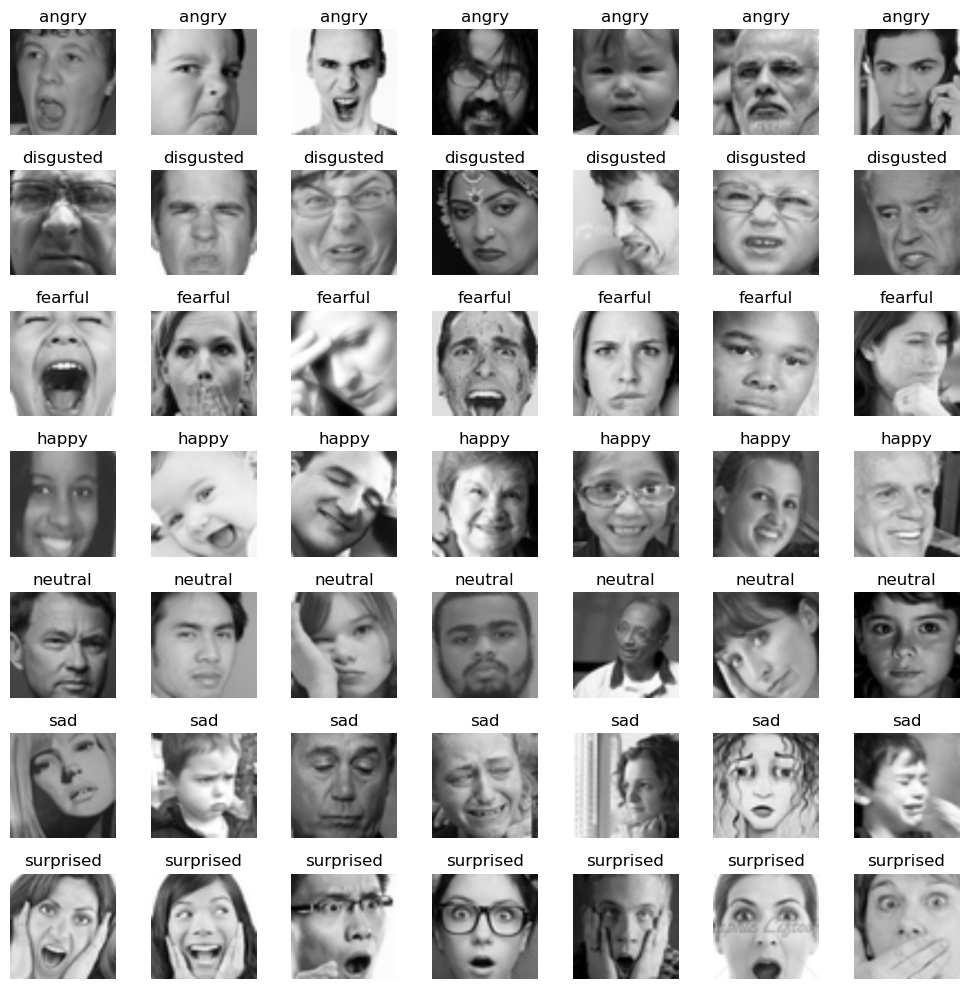

In [16]:
num_samples = 7  # Number of sample images to display per class

plt.figure(figsize=(10, 10))
position = 1
for i in range(len(class_names)):
    class_name = class_names[i] # class name[i]:(angry ,disgusted ,fearful ,happy ,neutral ,sad ,surprised)
    
    class_samples = data_df[data_df['class'] == class_name].sample(num_samples, random_state=40)  #It is pandas method used to take a subset of random rows or columns from pandas dataframe
    
    for j in range(len(class_samples.values)): # Access the values of the DataFrame as a NumPy array

        image, _ = class_samples.values[j]  # image ,_: contain class names
        plt.subplot(len(class_names), num_samples , position)
        plt.imshow(image)
        plt.title(_)
        plt.axis('off')
        position += 1 

plt.tight_layout()
plt.show()

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


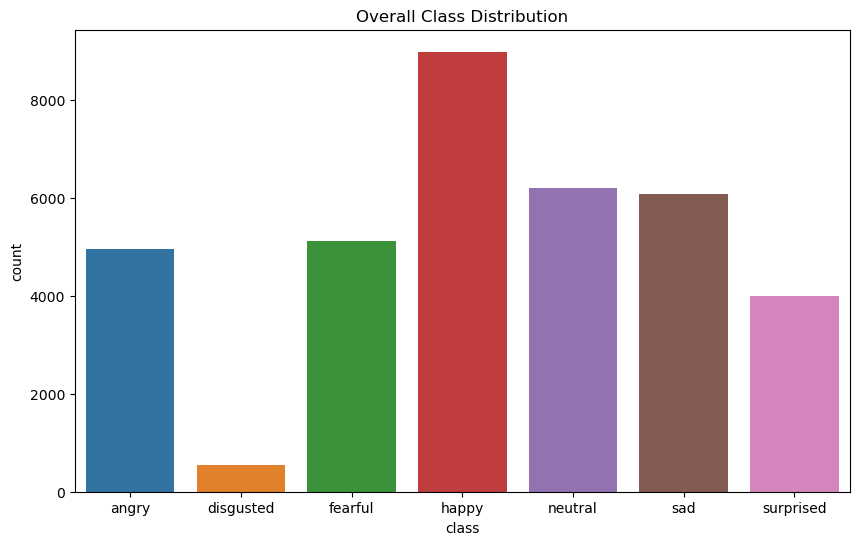

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=data_df)
plt.title('Overall Class Distribution')
plt.show()

In [20]:
class_distribution

class
happy        8989
neutral      6198
sad          6077
fearful      5121
angry        4953
surprised    4002
disgusted     547
Name: count, dtype: int64

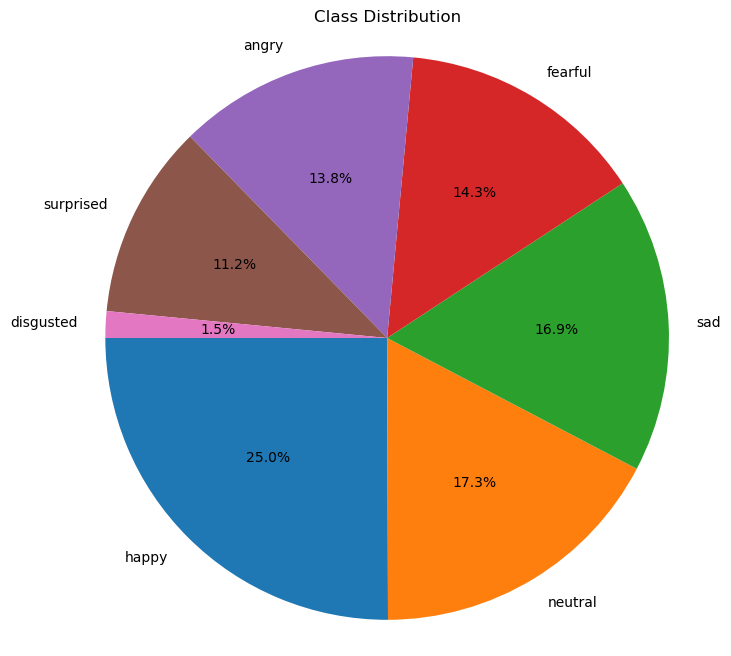

In [30]:
class_distribution = data_df['class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=180)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# Based on the above analysis, we will remove the disgusted class because it disperses the data

In [31]:
excluded_category = "disgusted"  # Define the category to be excluded from the training data

train_generator = ImageDataGenerator(  # Create an ImageDataGenerator for data augmentation
    rescale=1./255,  # Rescale pixel values to the range [0, 1]
    rotation_range=.3,  # Randomly rotate images within the range of 0 to 0.3 radians
    width_shift_range=.1,  # Randomly shift images horizontally by a fraction of 0.1 of the total width
    height_shift_range=.1,  # Randomly shift images vertically by a fraction of 0.1 of the total height
    shear_range=.1,  # Apply shearing transformation with a shear intensity of 0.1
    zoom_range=.2,  # Randomly zoom into images by a factor of 0.2
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    validation_split=0.2  # Set the validation split to separate a portion of the training data for validation
)

train_data = train_generator.flow_from_directory(  # Generate a training data generator from a directory
    directory=datadir_train,  # Specify the directory containing the training images
    subset='training',  # Select the subset of data for training
    classes=[category for category in catgories if category != excluded_category],  # Exclude the specified category from the training classes
    target_size=(224, 224),  # Resize images to a target size of 224x224 pixels
    batch_size=64  # Set the batch size for training data
)

Found 0 images belonging to 6 classes.


In [13]:
val_data = train_generator.flow_from_directory(
    directory=datadir_train,
    subset='validation',
    target_size=(224,224),
    classes=[category for category in catgories if category != excluded_category],
    batch_size=64
)

Found 5654 images belonging to 6 classes.


In [14]:
test_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=.3,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=.1,
    zoom_range=.2,
    horizontal_flip=True,
        vertical_flip=True
)


test_data = test_generator.flow_from_directory(
    directory=datadir_test,
    target_size=(224,224),
        classes=[category for category in catgories if category != excluded_category],
    batch_size=64
)

Found 7067 images belonging to 6 classes.


In [15]:
'''
the MobileNet model is used as a feature extraction base, 
while the subsequent fully connected layers are responsible for the classification task.
'''

mobilenet=keras.applications.mobilenet.MobileNet()
input_layer=mobilenet.input #access input layer
output_layer = mobilenet.layers[-2].output  # access the layer just before the final softmax layer, By using [-2].

# classfication

predict_layer = keras.layers.Dense(1024)(output_layer)
predict_layer = keras.layers.BatchNormalization()(predict_layer)
predict_layer = keras.layers.Activation('relu')(predict_layer)

predict_layer = keras.layers.Dense(512)(predict_layer)
predict_layer = keras.layers.BatchNormalization()(predict_layer)
predict_layer = keras.layers.Activation('relu')(predict_layer)

predict_layer = keras.layers.Dense(256)(predict_layer)
predict_layer = keras.layers.BatchNormalization()(predict_layer)
predict_layer = keras.layers.Activation('relu')(predict_layer)


predict_layer = keras.layers.Dense(6)(predict_layer)
predict_layer = keras.layers.Activation('softmax')(predict_layer)

mobilenet_Model = keras.Model(inputs=input_layer, outputs=predict_layer)




17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
mobilenet_Model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 5,943,726 (22.67 MB)

 Trainable params: 5,918,254 (22.58 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [17]:
mobilenet_Model.compile(optimizer='adam',
                loss='categorical_crossentropy',metrics=['accuracy'])

#we can use sparse_categorical_crossentropy if we not apply one hot encoder

In [18]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.0015,
                              patience=5,
                              verbose=1)


#monitor='val_loss': The metric to monitor for improvements. 

#factor=0.1: The factor by which the learning rate will be reduced. For example, if the learning rate is 0.001, and the factor is 0.2, the new learning rate will be 0.001 * 0.1 = 0.0001.

#patience=5: The number of epochs with no improvement after which the learning rate will be reduced. In this case, if the 'val_loss' does not improve after 5 epochs, the learning rate will be adjusted.

#verbose=1: Controls the verbosity of the output. If set to 1, it will display a message when the learning rate is reduced.

In [19]:
es= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
history=mobilenet_Model.fit(train_data,validation_data=val_data,
                          epochs=30,shuffle=True,verbose=1,callbacks=[es,reduce_lr]).history

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/354 ━━━━━━━━━━━━━━━━━━━━ 4:21:29 44s/step - accuracy: 0.1719 - loss: 2.0067

I0000 00:00:1710371856.231154     192 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.4137 - loss: 1.5129 - val_accuracy: 0.3115 - val_loss: 2.9883 - learning_rate: 0.0010
Epoch 2/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 289s 804ms/step - accuracy: 0.5688 - loss: 1.1221 - val_accuracy: 0.5799 - val_loss: 1.0805 - learning_rate: 0.0010
Epoch 3/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 289s 804ms/step - accuracy: 0.5960 - loss: 1.0447 - val_accuracy: 0.5923 - val_loss: 1.0880 - learning_rate: 0.0010
Epoch 4/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 290s 807ms/step - accuracy: 0.6207 - loss: 1.0003 - val_accuracy: 0.5819 - val_loss: 1.1283 - learning_rate: 0.0010
Epoch 5/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 289s 803ms/step - accuracy: 0.6334 - loss: 0.9698 - val_accuracy: 0.6059 - val_loss: 1.0484 - learning_rate: 0.0010
Epoch 6/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 289s 803ms/step - accuracy: 0.6309 - loss: 0.9626 - val_accuracy: 0.5730 - val_loss: 1.1288 - learning_rate: 0.0010
Epoch 7/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 289s 803ms/step - accuracy: 0.6400 - l

In [21]:
mobilenet_Model.evaluate(test_data)

111/111 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6376 - loss: 0.9749


[0.9796308875083923, 0.6387434601783752]

In [22]:
mobilenet_Model.save("emoition_today_final.h5")

In [34]:
model=load_model("emoition_today_final.h5")

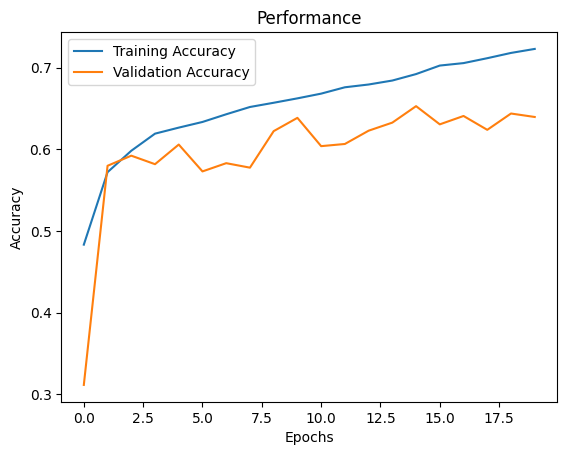

In [23]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

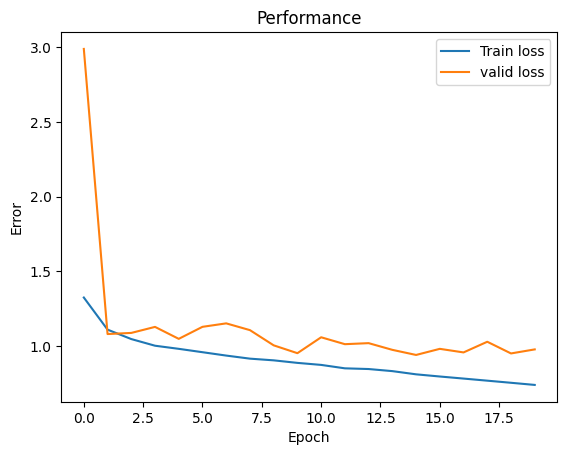

In [24]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(history['loss'], label='Train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.title('Performance')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

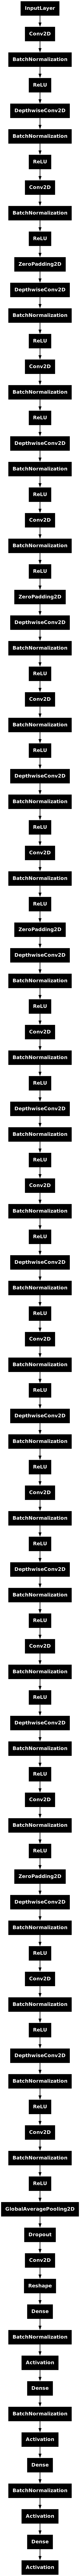

In [25]:
from keras.utils import plot_model
plot_model(mobilenet_Model, to_file='mode_plot.png')

In [26]:
y_prd=mobilenet_Model.predict(test_data)
y_prd = np.argmax(y_prd, axis=1)

111/111 ━━━━━━━━━━━━━━━━━━━━ 75s 657ms/step


In [49]:
test_data.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [28]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [29]:
print(classification_report(test_data.classes,y_prd))

              precision    recall  f1-score   support

           0       0.13      0.14      0.13       958
           1       0.14      0.08      0.10      1024
           2       0.27      0.28      0.27      1774
           3       0.17      0.24      0.20      1233
           4       0.18      0.16      0.17      1247
           5       0.10      0.08      0.09       831

    accuracy                           0.18      7067
   macro avg       0.16      0.16      0.16      7067
weighted avg       0.18      0.18      0.18      7067



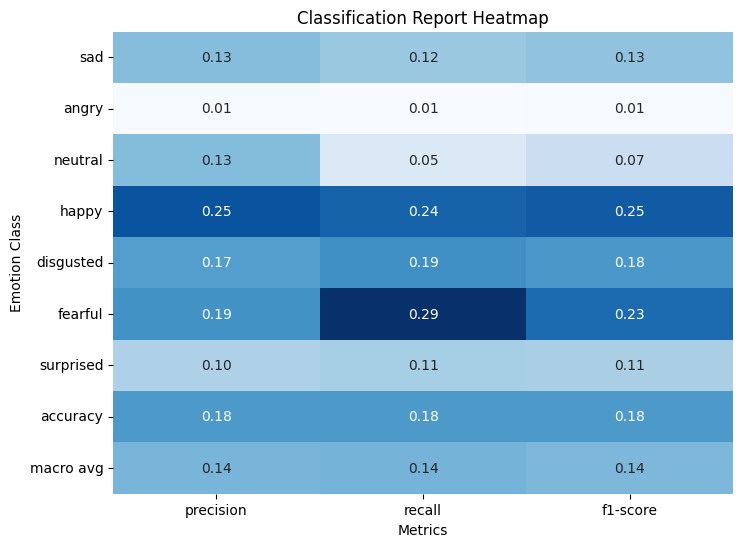

In [63]:
import seaborn as sns  # Importing the Seaborn data visualization library
from sklearn.metrics import classification_report  # Importing the classification report function
import pandas as pd  # Importing pandas for data manipulation

class_names = {"angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"}  # Define the emotion class names

report = classification_report(test_data.classes, y_prd, target_names=class_names, output_dict=True)  # Generate a classification report with target names and output as a dictionary
df_report = pd.DataFrame(report).transpose()  # Create a DataFrame from the classification report for visualization

plt.figure(figsize=(8, 6))  # Set the figure size for the heatmap visualization
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f", cbar=False)  # Create a heatmap with annotations, using the Blues color map, formatting numbers to 2 decimal places, and without a color bar
plt.xlabel('Metrics')  # Set the label for the x-axis
plt.ylabel('Emotion Class')  # Set the label for the y-axis
plt.title('Classification Report Heatmap')  # Set the title for the heatmap
plt.show()  # Display the heatmap visualization

# A Haar cascade file is a trained classifier that uses Haar-like features to detect objects or patterns.
## Haar cascade file is primarily used for face detection. It identifies the presence and location of faces in an image. Once the faces are detected, a deep learning model can be used to classify the expressions or emotions present in those detected faces.

In [32]:
import cv2  # Importing the OpenCV library for computer vision tasks
import numpy as np  # Importing NumPy for numerical operations

def detect_emotion1(model, haarcascade_path, image_path):
    # Load the Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(haarcascade_path)  # Loading the Haar Cascade classifier for face detection

    frame = cv2.imread(image_path)  # Reading the input image

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Converting the image to grayscale for processing

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)  # Detecting faces in the grayscale image

    bounding_boxes = []  # Store bounding box coordinates for each face detected
    emotions = []  # Store predicted emotions for each face detected

    for x, y, w, h in faces:
        roi_gray = gray[y:y + h, x:x + w]  # Selecting the region of interest in grayscale
        roi_color = frame[y:y + h, x:x + w]  # Selecting the region of interest in color

        # Perform face-level emotion detection
        final_image = cv2.resize(roi_color, (224, 224))  # Resizing the region of interest
        final_image = np.expand_dims(final_image, axis=0)  # Adding a batch dimension
        final_image = final_image / 255.0  # Normalizing pixel values

        predictions = model.predict(final_image)  # Making predictions using the provided model

        # Determine the predicted emotion
        emotion_labels = ["angry", "fearful", "happy", "neutral", "sad", "surprised"]  # List of emotion labels
        predicted_emotion = emotion_labels[np.argmax(predictions)]  # Selecting the emotion with the highest probability

        bounding_boxes.append((x, y, w, h))  # Storing the bounding box coordinates
        emotions.append(predicted_emotion)  # Storing the predicted emotion

    # Display the emotions for each face detected
    for (x, y, w, h), emotion in zip(bounding_boxes, emotions):
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)  # Adding text to the image
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Drawing a rectangle around the detected face

    cv2.imshow("Facial Emotion Detection", frame)  # Displaying the image with emotions
    cv2.waitKey(0)  # Waiting for a key press
    cv2.destroyAllWindows()  # Closing all OpenCV windows
    cv2.imwrite("output.jpg", frame)  # Saving the output image

In [58]:
detect_emotion1(model,'haarcascade_frontalface_default.xml', 'happ4.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [224]:

'''
emotion_labels = ["angry", "fearful", "happy", "neutral", "sad", "surprised"]

def transform_pred(model, image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))  # Display the image
    plt.axis('off')
    plt.show()
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img=img/255.0
    img = np.array(img).reshape(-1, 224, 224, 3)
    pred = model.predict(img)
    transformed_pred = []
    for i in range(len(pred)):
        decoded_pred = np.argmax(pred[i])
        transformed_pred.append(emotion_labels[decoded_pred])
    return transformed_pred
'''

'\nemotion_labels = ["angry", "fearful", "happy", "neutral", "sad", "surprised"]\n\ndef transform_pred(model, image_path):\n    img = cv2.imread(image_path)\n    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))  # Display the image\n    plt.axis(\'off\')\n    plt.show()\n    img = cv2.resize(img, (224, 224))\n    img = np.expand_dims(img, axis=0)\n    img=img/255.0\n    img = np.array(img).reshape(-1, 224, 224, 3)\n    pred = model.predict(img)\n    transformed_pred = []\n    for i in range(len(pred)):\n        decoded_pred = np.argmax(pred[i])\n        transformed_pred.append(emotion_labels[decoded_pred])\n    return transformed_pred\n'

In [225]:
#transform_pred(model,'image_emo.jpg')

In [226]:
#transform_pred(model,'images (6).jpeg')

In [227]:
#transform_pred(model,'download (2).jpeg')

In [228]:
#transform_pred(model,'download (5).jpeg')

In [229]:
#transform_pred(model,'download (1).jpeg')

In [230]:
#transform_pred(model,'angry.jpeg')

In [221]:
import cv2
import numpy as np

def detect_emotion(model, haarcascade_path):
    # Load the Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(haarcascade_path)

    cap = cv2.VideoCapture(0)  # Use webcam (ID 0)

    while True:
        ret, frame = cap.read()

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        bounding_boxes = []  # Store bounding box coordinates for each face detected
        emotions = []  # Store predicted emotions for each face detected

        for x, y, w, h in faces:
            roi_gray = gray[y:y + h, x:x + w]
            roi_color = frame[y:y + h, x:x + w]

            # Perform face-level emotion detection
            final_image = cv2.resize(roi_color, (224, 224))
            final_image = np.expand_dims(final_image, axis=0)
            final_image = final_image / 255.0

            predictions = model.predict(final_image)

            # Determine the predicted emotion
            emotion_labels = ["angry","fearful","happy","neutral","sad","surprised"]
            predicted_emotion = emotion_labels[np.argmax(predictions)]

            bounding_boxes.append((x, y, w, h))  # Store bounding box coordinates
            emotions.append(predicted_emotion)  # Store predicted emotion

        # Display the emotions for each face detected
        for (x, y, w, h), emotion in zip(bounding_boxes, emotions):
            cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        cv2.imshow("Facial Emotion Detection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [222]:
detect_emotion(model,'haarcascade_frontalface_default.xml')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 